In [1]:
import ROOT
from ROOT import TFile
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import pandas as pd 
import time
import root_pandas as rpd
from root_pandas import read_root

mpl.rcParams['figure.figsize'] = 6.2,3.5
mpl.rcParams['axes.labelsize'] = 17
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.markersize'] = 6
mpl.rcParams['legend.fontsize']= 15

Welcome to JupyROOT 6.15/01


In [2]:
def getRatio(df_A,df_D,df_trigger_A,df_trigger_D, variable='z_asso',trig_cut = 'z>0.5', pair_cut='',minz=0.08,maxz=0.45,nbins=9):
    #get number of pions with z>0.5
    print 'Print Trigger Cut ' ,trig_cut
    print 'Total Cut ', trig_cut + pair_cut
    
    norm_A = df_trigger_A.query(trig_cut).shape[0]
    norm_D = df_trigger_D.query(trig_cut).shape[0]
    print 'Number of triggers A', norm_A
    print 'Number of triggers D', norm_D
    
    y_A, x_conditional = np.histogram(df_A.query(trig_cut+pair_cut)[variable],bins=np.logspace(np.log10(minz), np.log10(maxz),nbins))
    y_D, x_conditional = np.histogram(df_D.query(trig_cut+pair_cut)[variable],bins=np.logspace(np.log10(minz), np.log10(maxz),nbins))
    x_conditional = (x_conditional[1:] + x_conditional[:-1])/2.0
    err_A = np.true_divide(np.sqrt(y_A),y_A)
    err_D = np.true_divide(np.sqrt(y_D),y_D)
    y_A = np.true_divide(y_A,norm_A)
    y_D = np.true_divide(y_D,norm_D)
    ratio_conditional = np.true_divide(y_A,y_D)
    error_conditional = np.multiply(ratio_conditional, np.sqrt(np.power(err_A,2.0) + np.power(err_D,2.0)))
    
    return ratio_conditional,error_conditional,x_conditional

In [3]:
def applyCut(inputDataframe, cut, text=None):
    nbeforecut = inputDataframe.shape[0]
    if nbeforecut>0:
        cutDataframe = inputDataframe.query(cut)
        if text:
            print text, cutDataframe.shape[0], ' (%2.2f '%(100.0*cutDataframe.shape[0]/nbeforecut), '%)'
    return cutDataframe
def applyCuts(fullDataframe,name='default',isMC=False): 
    dataframe = fullDataframe
    print 'Entries before cut ', dataframe.shape[0]
    dataframe.eval('inelasticity = Nu/5.014', inplace=True)
    dataframe.eval('E = z*Nu', inplace=True)
    dataframe.eval('P = sqrt(E*E-0.140*0.140)', inplace=True)
    
    dataframe = applyCut(dataframe, 'Q2>1.0', 'Q2>1.0 :')
    #dataframe = applyCut(dataframe, 'Nu>3.0 and Nu<3.5', '3.0 < Nu < 3.5')
    dataframe = applyCut(dataframe, 'z>0.5', 'z>0.5 :')
    dataframe = applyCut(dataframe, 'P <2.5 ', 'P<2.5 ')

    dataframe = applyCut(dataframe, 'inelasticity<0.85','inelasticity < 0.85')
    return dataframe

def applyCutsPair(fullDataframe,name='default',isMC=False):
    print 'Starting election on dipion variables'
    if (isMC):
        print 'This is MC'
    else: 
        print 'This is Data'
    
    dataframe = fullDataframe
    dataframe.eval('z_tot = z+z_asso', inplace=True)
    dataframe.eval('E_asso = z_asso*Nu', inplace=True)
    dataframe.eval('P_asso = sqrt(E_asso*E_asso-0.140*0.140)', inplace=True)
    
    dataframe = applyCut(dataframe, 'Q2>1.0', 'Q2>1.0 :')
    #dataframe = applyCut(dataframe, 'Nu>3.0 and Nu<3.5', '3.0 < Nu < 3.5')
    dataframe = applyCut(dataframe, 'z>0.5', 'z>0.5 :')
    dataframe = applyCut(dataframe, 'P <2.5 ', 'P<2.5 ')

    dataframe = applyCut(dataframe, 'pid*pid_asso<0', 'Opposite sign pairs')
    
    ##Polar angle acceptance, different for 
    #if(isMC==False):
    #    print 'Polar angle acceptance'
    #    dataframe = applyCut(dataframe,'(pid_asso==211 & theta_lab_asso>10 & theta_lab_asso<90)|(pid_asso==-211 & theta_lab_asso>45 & theta_lab_asso<90)')
    #dataframe = applyCut(dataframe, '(pid_asso==211 & P_asso>0.200) |(pid_asso==-211 & P_asso>0.300) ', 'pi+ P_asso > 200 MeV, pi- P_asso > 300 MeV')
    dataframe = applyCut(dataframe, 'P_asso<2.5', 'P_asso <2.5 GeV')
    #dataframe = applyCut(dataframe, 'mass<1.4', 'mass < 1.4 GeV')
    
    return dataframe

def printPairBreakdown(dataframe):
    allpairs = 1.0*dataframe.shape[0]
    print 'All pairs ', allpairs
    print 'Pairs with Leading pi+', np.true_divide(dataframe.query('pid==211').shape[0],allpairs)
    print 'Pairs with Leading pi-', dataframe.query('pid==-211').shape[0]/allpairs
    print 'Pairs with Sub-Leading pi+', dataframe.query('pid_asso==211').shape[0]/allpairs
    print 'Pairs with Sub-Leading pi-', dataframe.query('pid_asso==-211').shape[0]/allpairs
    print 'pi+ pi+ pairs',dataframe.query('pid==211 and pid_asso==211').shape[0]/allpairs
    print 'pi- pi- pairs',dataframe.query('pid==-211 and pid_asso==-211').shape[0]/allpairs
    print 'pi+ pi- pairs',dataframe.query('pid==211 and pid_asso==-211').shape[0]/allpairs
    print 'pi- pi+ pairs',dataframe.query('pid==-211 and pid_asso==211').shape[0]/allpairs
    print '//////////////////////////////////////////////////////'
    return 


## Get data from Ntuples to dataframes

In [4]:
#this needs to be read in chunks otherwise it uses all memory. (from https://github.com/scikit-hep/root_pandas)
def getdatainChunks(filename,treename):
    dataframe =pd.DataFrame()
    for df in read_root(filename, treename, chunksize=100000) :
        #print df.shape[0]
        dataframe = pd.concat([dataframe,df])
    
    print dataframe.shape[0]
    return dataframe
    

## Get data

In [5]:
df = {}
df_trigger = {}

for target in ['C','Fe','Pb']:
    print 'Getting dataframes from target %s'%target
    df[target]=getdatainChunks('Pairs_%s.root'%target, target)
    df['D_%s'%target]= getdatainChunks('Pairs_%s.root'%target, 'D_%s'%target)  
    print 'Get trigger dataframes from deuterium target %s'%target
    df_trigger['%s_trigger'%target] = getdatainChunks('Pairs_%s.root'%target, '%s_trigger'%target)
    df_trigger['D_%s_trigger'%target] = getdatainChunks('Pairs_%s.root'%target, 'D_%s_trigger'%target)

Getting dataframes from target C
294942
395135
Get trigger dataframes from deuterium target C
1218503
1599452
Getting dataframes from target Fe
401683
715969
Get trigger dataframes from deuterium target Fe
1774824
2886931
Getting dataframes from target Pb
110447
574977
Get trigger dataframes from deuterium target Pb
527766
2349115


## GiBUU 

In [6]:
for target in ['D','C','Fe','Pb']:
    #GiBUU
    print target
    print ' trigger'
    df_trigger['GiBUU_%s_trigger'%target]= getdatainChunks('GiBUU_Pairs_%s.root'%target, '%s_trigger'%target)
    print ' pairs'
    df['GiBUU_%s'%target]= getdatainChunks('GiBUU_Pairs_%s.root'%target, target)
print df.keys()

D
 trigger
478988
 pairs
299863
C
 trigger
238611
 pairs
150219
Fe
 trigger
166850
 pairs
102825
Pb
 trigger
145708
 pairs
89141
['C', 'GiBUU_C', 'GiBUU_Fe', 'GiBUU_D', 'GiBUU_Pb', 'Pb', 'Fe', 'D_C', 'D_Fe', 'D_Pb']


## Combine the deuterium datasets 

In [7]:
df['D'] = pd.concat([df['D_Pb'],df['D_Fe'],df['D_C']]) #simply combine the deuterium results for all targets
df_trigger['D_trigger'] = pd.concat([df_trigger['D_Pb_trigger'],df_trigger['D_Fe_trigger'],df_trigger['D_C_trigger']]) #simply combine the deuterium results for all targets



## Apply selection for pair ntuples

In [8]:
print df.keys()

['C', 'D', 'GiBUU_C', 'GiBUU_Fe', 'GiBUU_D', 'GiBUU_Pb', 'Pb', 'Fe', 'D_C', 'D_Fe', 'D_Pb']


In [9]:
#dataframees with pairs
for key in df.keys():
    isMC = False
    if 'GiBUU' in key:
        isMC=True
    print key
    
    df[key] = applyCuts(df[key],isMC=isMC)
    printPairBreakdown(df[key])
    df[key] = applyCutsPair(df[key],isMC=isMC)
    print ' '

C
Entries before cut  294942
Q2>1.0 : 294942  (100.00  %)
z>0.5 : 133831  (45.38  %)
P<2.5  116838  (87.30  %)
inelasticity < 0.85 113394  (97.05  %)
All pairs  113394.0
Pairs with Leading pi+ 0.8031818261989171
Pairs with Leading pi- 0.196818173801
Pairs with Sub-Leading pi+ 0.474319628905
Pairs with Sub-Leading pi- 0.525680371095
pi+ pi+ pairs 0.284953348502
pi- pi- pairs 0.00745189339824
pi+ pi- pairs 0.518228477697
pi- pi+ pairs 0.189366280403
//////////////////////////////////////////////////////
Starting election on dipion variables
This is Data
Q2>1.0 : 113394  (100.00  %)
z>0.5 : 113394  (100.00  %)
P<2.5  113394  (100.00  %)
Opposite sign pairs 80237  (70.76  %)
P_asso <2.5 GeV 80178  (99.93  %)
 
D
Entries before cut  1686081
Q2>1.0 : 1686081  (100.00  %)
z>0.5 : 802624  (47.60  %)
P<2.5  696928  (86.83  %)
inelasticity < 0.85 680119  (97.59  %)
All pairs  680119.0
Pairs with Leading pi+ 0.7914806085405642
Pairs with Leading pi- 0.208519391459
Pairs with Sub-Leading pi+ 0.438

## Apply cuts for trigger dataframes

In [10]:
for key in df_trigger.keys():
    print key
    df_trigger[key] = applyCuts(df_trigger[key])
    print ' ' 

D_C_trigger
Entries before cut  1599452
Q2>1.0 : 1599452  (100.00  %)
z>0.5 : 931192  (58.22  %)
P<2.5  751869  (80.74  %)
inelasticity < 0.85 737719  (98.12  %)
 
D_trigger
Entries before cut  6835498
Q2>1.0 : 6835498  (100.00  %)
z>0.5 : 3984109  (58.29  %)
P<2.5  3217923  (80.77  %)
inelasticity < 0.85 3159174  (98.17  %)
 
D_Pb_trigger
Entries before cut  2349115
Q2>1.0 : 2349115  (100.00  %)
z>0.5 : 1370279  (58.33  %)
P<2.5  1107388  (80.81  %)
inelasticity < 0.85 1086970  (98.16  %)
 
Pb_trigger
Entries before cut  527766
Q2>1.0 : 527766  (100.00  %)
z>0.5 : 291255  (55.19  %)
P<2.5  239158  (82.11  %)
inelasticity < 0.85 233659  (97.70  %)
 
GiBUU_C_trigger
Entries before cut  238611
Q2>1.0 : 238611  (100.00  %)
z>0.5 : 238611  (100.00  %)
P<2.5  125555  (52.62  %)
inelasticity < 0.85 125555  (100.00  %)
 
GiBUU_Fe_trigger
Entries before cut  166850
Q2>1.0 : 166850  (100.00  %)
z>0.5 : 166850  (100.00  %)
P<2.5  88694  (53.16  %)
inelasticity < 0.85 88694  (100.00  %)
 
Fe_trig

## R_2h data from HERMES and Neutrino buble-chamber experiment

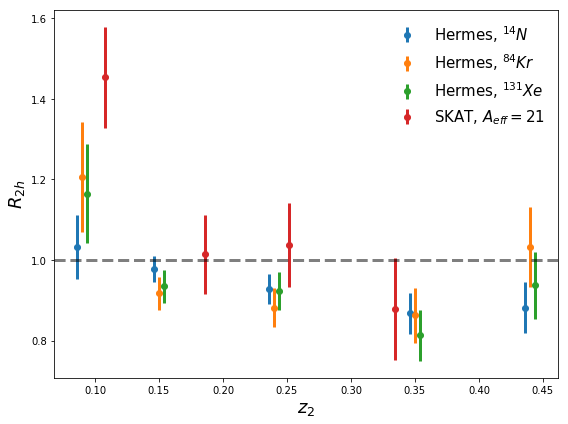

In [11]:
#hermes data:
hermes_y = {}
hermes_ystat = {}
hermes_ysyst = {}
hermes_ytotal = {}

#DATA FROM SELECTIO1 OF http://www-hermes.desy.de/notes/pub/publications.html
hermes_x = {}
hermes_x['Kr'] = [0.09,0.15,0.24,0.35,0.44]
hermes_x['N'] = np.subtract(hermes_x['Kr'],0.004)
hermes_x['Xe'] = np.subtract(hermes_x['Kr'],-0.004)

#nitrogen, atomic number 7
hermes_y['N']     = [1.0324, 0.9781,0.9293,0.8678,0.8822]
hermes_ystat['N'] = [0.0767,0.0268,0.0323,0.0478,0.0601]
hermes_ysyst['N'] = [0.0206,0.0196,0.0186,0.0174,0.0176]
hermes_ytotal['N'] = np.sqrt(np.power(hermes_ystat['N'],2.0)+np.power(hermes_ysyst['N'],2.0))

#krypton, atomic number 36
hermes_y['Kr'] = [1.2072,0.9180,0.8822,0.8631,1.0314]
hermes_ystat['Kr'] = [0.1342,0.0366,0.0452,0.0661,0.0972]
hermes_ysyst['Kr'] =[0.0241,0.0184,0.0176,0.0173,0.0206]
hermes_ytotal['Kr'] = np.sqrt(np.power(hermes_ystat['Kr'],2.0)+np.power(hermes_ysyst['Kr'],2.0))

hermes_y['Xe'] = [1.1648,0.9345,0.9242,0.8128,0.9373]
hermes_ystat['Xe'] = [0.1205,0.0359,0.0433,0.0614,0.0808]
hermes_ysyst['Xe'] = [0.0233,0.0187,0.0185,0.0163,0.0187]
hermes_ytotal['Xe'] = np.sqrt(np.power(hermes_ystat['Xe'],2.0)+np.power(hermes_ysyst['Xe'],2.0))


neutrino_x = [0.10763636363636367, 0.18618181818181817,0.25163636363636366,0.3345454545454546]
neutrino_y = [1.4535664335664338, 1.0148378893833438,  1.0373426573426574, 0.8784361093452003]
neutrino_yerror =[1.5794405594405596, 1.112739987285442, 1.1422377622377624,1.004310235219326]
neutrino_yerror = np.subtract(neutrino_yerror,neutrino_y)

fig = plt.figure(figsize=(8,6))



plt.errorbar(hermes_x['N'], hermes_y['N'],yerr=hermes_ytotal['N'],label='Hermes, $^{14}N$',fmt='o')
plt.errorbar(hermes_x['Kr'], hermes_y['Kr'],yerr=hermes_ytotal['Kr'],label='Hermes, $^{84}Kr$',fmt='o')
plt.errorbar(hermes_x['Xe'], hermes_y['Xe'],yerr=hermes_ytotal['Xe'],label='Hermes, $^{131}Xe$',fmt='o')
plt.errorbar(neutrino_x, neutrino_y,yerr=neutrino_yerror,label='SKAT, $A_{eff}=21$',fmt='o')
plt.xlabel('$z_{2}$',fontsize=18)
plt.ylabel('$R_{2h}$',fontsize=18)
plt.axhline(y=1.0,color='black',linestyle='--',alpha=0.5)

plt.tight_layout()
plt.legend(frameon=False)
plt.savefig('PreviousData.png')
plt.show()

Print Trigger Cut  z>0.5
Total Cut  z>0.5
Number of triggers A 554394
Number of triggers D 737719
Print Trigger Cut  z>0.5
Total Cut  z>0.5
Number of triggers A 795107
Number of triggers D 1334485
Print Trigger Cut  z>0.5
Total Cut  z>0.5
Number of triggers A 233659
Number of triggers D 1086970


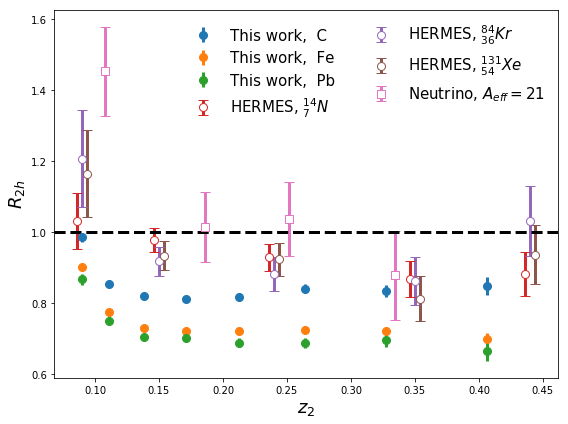

In [12]:
fig = plt.figure(figsize=(8,6))

for target in ['C','Fe','Pb']:
    r, err,x = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.08)
    plt.errorbar(x,r,yerr=err,label='This work,  %s'%target,fmt='o',ms=8)

plt.xlabel('$z_{2}$',fontsize=18)
plt.ylabel('$R_{2h}$',fontsize=18)

plt.errorbar(hermes_x['N'], hermes_y['N'],yerr=hermes_ytotal['N'],fmt='o',mfc='white',label='HERMES, $^{14}_{7}N$',fillstyle=None,ms=8,capsize=5)
plt.errorbar(hermes_x['Kr'], hermes_y['Kr'],yerr=hermes_ytotal['Kr'],fmt='o',mfc='white',label='HERMES, $^{84}_{36}Kr$',fillstyle=None,ms=8,capsize=5)
plt.errorbar(hermes_x['Xe'], hermes_y['Xe'],yerr=hermes_ytotal['Xe'],fmt='o',mfc='white',label='HERMES, $^{131}_{54}Xe$',fillstyle=None,ms=8,capsize=5)
plt.errorbar(neutrino_x, neutrino_y,yerr=neutrino_yerror,fmt='s',mfc='white',label='Neutrino, $A_{eff}=21$',fillstyle=None,ms=8,capsize=5)

#plt.ylim([0.5,1.5])
#plt.xlim([0.00,0.5])
plt.axhline(y=1.0,color='black',linestyle='--')
plt.legend(loc='best',frameon=False,fontsize=15,ncol=2)

plt.tight_layout()
plt.savefig('ComparisonWithHermes_Linear.png')
#plt.xlim([0.05,0.5])

#plt.xscale('log')
#plt.savefig('ComparisonWithHermes_Log.png')

plt.show()

## Theory only

Print Trigger Cut  z>0.5
Total Cut  z>0.5
Number of triggers A 125555
Number of triggers D 246157
Print Trigger Cut  z>0.5
Total Cut  z>0.5
Number of triggers A 88694
Number of triggers D 246157
Print Trigger Cut  z>0.5
Total Cut  z>0.5
Number of triggers A 77738
Number of triggers D 246157


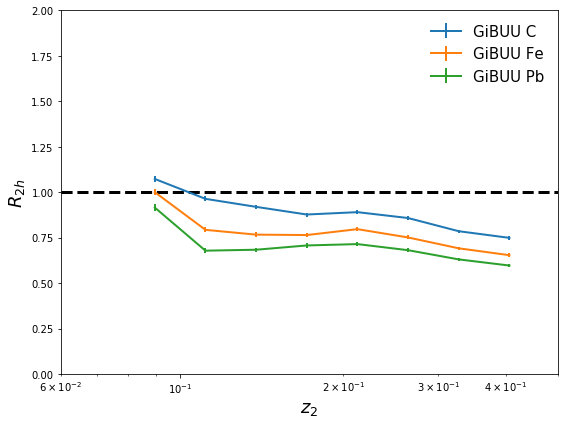

In [13]:
fig = plt.figure(figsize=(8,6))

for target in ['C','Fe','Pb']:
    r, err,x = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'])
    plt.errorbar(x,r,yerr=err,label='GiBUU %s'%target,ms=8,lw=2)

plt.xlabel('$z_{2}$',fontsize=18)
plt.ylabel('$R_{2h}$',fontsize=18)

plt.xlim([0.06,0.5])
plt.ylim([0.0,2.0])

plt.axhline(y=1.0,color='black',linestyle='--')
plt.legend(loc='best',frameon=False,fontsize=15,ncol=1)


plt.xscale('log')

plt.tight_layout()
plt.savefig('TheoryOnly.png')

## Result compared with GiBUU

Print Trigger Cut  z>0.5
Total Cut  z>0.5
Number of triggers A 554394
Number of triggers D 737719
Print Trigger Cut  z>0.5
Total Cut  z>0.5
Number of triggers A 125555
Number of triggers D 246157
Print Trigger Cut  z>0.5
Total Cut  z>0.5
Number of triggers A 795107
Number of triggers D 1334485
Print Trigger Cut  z>0.5
Total Cut  z>0.5
Number of triggers A 88694
Number of triggers D 246157
Print Trigger Cut  z>0.5
Total Cut  z>0.5
Number of triggers A 233659
Number of triggers D 1086970
Print Trigger Cut  z>0.5
Total Cut  z>0.5
Number of triggers A 77738
Number of triggers D 246157


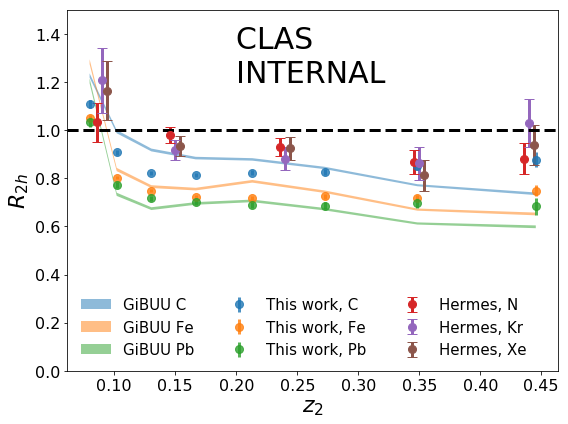

In [20]:
fig = plt.figure(figsize=(8,6))


for i,target in enumerate(['C','Fe','Pb']):
    r, err,x = getRatio(df['%s'%target], df['D_%s'%target], df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target]
                       ,variable='z_asso',minz=0.07,maxz=0.5#,pair_cut='and z_asso>0.1'
                       )
    plt.errorbar(np.subtract(x,0*0.0025),r,yerr=err,label='This work, %s'%target,ms=8,fmt='o',alpha=0.8)

    r, err,x = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger']
                       ,variable='z_asso',minz=0.07,maxz=0.5#,pair_cut='and z_asso>0.1'
                       )
    plt.fill_between(x,r,r-err,r+err,label='GiBUU %s'%target,alpha=0.5)

#plt.xscale('log')
plt.xlabel('$z_2$',fontsize=22)
plt.ylabel('$R_{2h}$',fontsize=22)
plt.axhline(y=1.0,color='black',linestyle='--')
plt.ylim([0.0,1.5])
plt.tight_layout()
plt.savefig('MainResult_withGiBUU_z2.png')


plt.errorbar(hermes_x['N'], hermes_y['N'],yerr=hermes_ytotal['N'],fmt='o',label='Hermes, N',fillstyle=None,ms=8,capsize=5)
plt.errorbar(hermes_x['Kr'], hermes_y['Kr'],yerr=hermes_ytotal['Kr'],fmt='o',label='Hermes, Kr',fillstyle=None,ms=8,capsize=5)
plt.errorbar(hermes_x['Xe'], hermes_y['Xe'],yerr=hermes_ytotal['Xe'],fmt='o',label='Hermes, Xe',fillstyle=None,ms=8,capsize=5)
#plt.errorbar(neutrino_x, neutrino_y,yerr=neutrino_yerror,fmt='s',mfc='white',label='Neutrino, $A_{eff}=21$',fillstyle=None,ms=8,capsize=5)

plt.tick_params(axis="x", labelsize=16)
plt.tick_params(axis="y", labelsize=16)
plt.text(0.20, 1.2, 'CLAS \nINTERNAL', fontsize=30)

plt.legend(frameon=False,ncol=3,fontsize=15)
plt.tight_layout()
plt.savefig('MainResult_withGiBUU_z2_withHERMES.png')
plt.savefig('MainResult_withGiBUU_z2_withHERMES.pdf')


## Results vs GiBUU (mass)

Print Trigger Cut  z>0.5
Total Cut  z>0.5and z_asso>0.15
Number of triggers A 554394
Number of triggers D 737719
Print Trigger Cut  z>0.5
Total Cut  z>0.5and z_asso>0.15
Number of triggers A 125555
Number of triggers D 246157
Print Trigger Cut  z>0.5
Total Cut  z>0.5and z_asso>0.15
Number of triggers A 795107
Number of triggers D 1334485
Print Trigger Cut  z>0.5
Total Cut  z>0.5and z_asso>0.15
Number of triggers A 88694
Number of triggers D 246157
Print Trigger Cut  z>0.5
Total Cut  z>0.5and z_asso>0.15
Number of triggers A 233659
Number of triggers D 1086970
Print Trigger Cut  z>0.5
Total Cut  z>0.5and z_asso>0.15
Number of triggers A 77738
Number of triggers D 246157


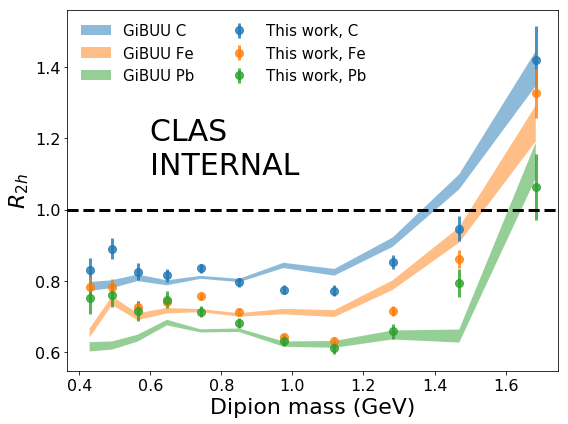

In [19]:
fig = plt.figure(figsize=(8,6))


for target in ['C','Fe','Pb']:
    r, err,x = getRatio(df['%s'%target], df['D_%s'%target], df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target]
                       ,variable='mass',minz=0.4,maxz=1.8,nbins=12,pair_cut='and z_asso>0.15'
                       )
    plt.errorbar(x,r,yerr=err,label='This work, %s'%target,ms=8,fmt='o',alpha=0.8)

    r, err,x = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger']
                       ,variable='mass',minz=0.4,maxz=1.8,nbins=12,pair_cut='and z_asso>0.15'
                       )
    plt.fill_between(x,r,r-err,r+err,label='GiBUU %s'%target,alpha=0.5)

plt.tick_params(axis="x", labelsize=16)
plt.tick_params(axis="y", labelsize=16)
plt.legend(frameon=False,ncol=2)
plt.xlabel('Dipion mass (GeV)',fontsize=22)
plt.ylabel('$R_{2h}$',fontsize=22)
plt.axhline(y=1.0,color='black',linestyle='--')

plt.text(0.60, 1.1, 'CLAS \nINTERNAL', fontsize=30)

#plt.ylim([0.0,1.2])
plt.tight_layout()
plt.savefig('MainResult_withGiBUU_mass.png')
plt.savefig('MainResult_withGiBUU_mass.pdf')

Print Trigger Cut  z>0.5
Total Cut  z>0.5and z_asso>0.15
Number of triggers A 554394
Number of triggers D 737719
Print Trigger Cut  z>0.5
Total Cut  z>0.5and z_asso>0.15
Number of triggers A 125555
Number of triggers D 246157
Print Trigger Cut  z>0.5
Total Cut  z>0.5and z_asso>0.15


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python2.7/dist-packages/numpy/core/function_base.py:133: RuntimeWarning: invalid value encountered in multiply
  y *= step
/usr/local/lib/python2.7/dist-packages/numpy/core/function_base.py:142: RuntimeWarning: invalid value encountered in add
  y += start
/usr/local/lib/python2.7/dist-packages/numpy/lib/histograms.py:367: RuntimeWarning: invalid value encountered in greater
  if np.any(bin_edges[:-1] > bin_edges[1:]):
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide

Number of triggers A 795107
Number of triggers D 1334485
Print Trigger Cut  z>0.5
Total Cut  z>0.5and z_asso>0.15
Number of triggers A 88694
Number of triggers D 246157
Print Trigger Cut  z>0.5
Total Cut  z>0.5and z_asso>0.15
Number of triggers A 233659
Number of triggers D 1086970
Print Trigger Cut  z>0.5
Total Cut  z>0.5and z_asso>0.15
Number of triggers A 77738
Number of triggers D 246157


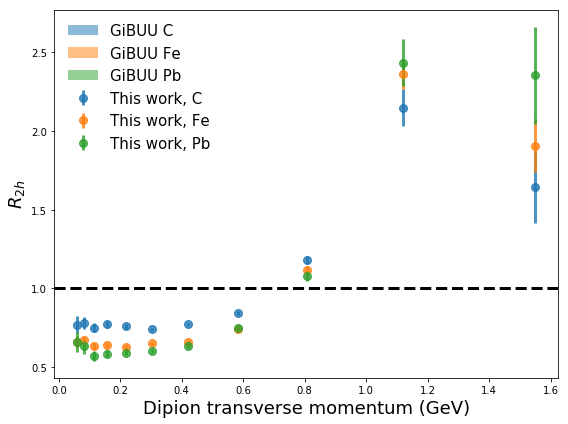

In [16]:
fig = plt.figure(figsize=(8,6))


for target in ['C','Fe','Pb']:
    r, err,x = getRatio(df['%s'%target], df['D_%s'%target], df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target]
                       ,variable='dipion_pt',minz=0.05,maxz=1.8,nbins=12,pair_cut='and z_asso>0.15'
                       )
    plt.errorbar(x,r,yerr=err,label='This work, %s'%target,ms=8,fmt='o',alpha=0.8)

    r, err,x = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger']
                       ,variable='dipion_pt',minz=0.0,maxz=1.8,nbins=12,pair_cut='and z_asso>0.15'
                       )
    plt.fill_between(x,r,r-err,r+err,label='GiBUU %s'%target,alpha=0.5)


plt.legend(frameon=False)
plt.xlabel('Dipion transverse momentum (GeV)',fontsize=18)
plt.ylabel('$R_{2h}$',fontsize=18)
plt.axhline(y=1.0,color='black',linestyle='--')

plt.tight_layout()
plt.savefig('MainResult_withGiBUU_mass.png')

## Results vs GiBUU (momentum P2)

In [ ]:
fig = plt.figure(figsize=(8,6))


for target in ['C','Fe','Pb']:
    r, err,x = getRatio(df['%s'%target], df['D_%s'%target], df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target]
                       ,variable='P_asso',minz=0.250,maxz=1.0,nbins=7
                       )
    plt.errorbar(x,r,yerr=err,label='This work, %s'%target,ms=8,fmt='o',alpha=0.8)

    r, err,x = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger']
                       ,variable='P_asso',minz=0.250,maxz=1.0,nbins=7
                       )
    plt.fill_between(x,r,r-err,r+err,label='GiBUU %s'%target,alpha=0.5)

#plt.xscale('log')
plt.legend(frameon=False)
plt.xlabel('$P_{2}$ (GeV)',fontsize=18)
plt.ylabel('$R_{2h}$',fontsize=18)
plt.axhline(y=1.0,color='black',linestyle='--')

plt.tight_layout()
plt.savefig('GiBUU_Momentum.png')

## Results vs GiBUU (ztot)

In [ ]:
fig = plt.figure(figsize=(8,6))


for target in ['C','Fe','Pb']:
    r, err,x = getRatio(df['%s'%target], df['D_%s'%target], df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target]
                       ,variable='z_tot',minz=0.56,maxz=1.0,nbins=15
                       )
    plt.errorbar(x,r,yerr=err,label='This work, %s'%target,ms=8,fmt='o',alpha=0.8)

    r, err,x = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger']
                       ,variable='z_tot',minz=0.56,maxz=1.0,nbins=15
                       )
    plt.fill_between(x,r,r-err,r+err,label='GiBUU %s'%target,alpha=0.5)

plt.xscale('log')
plt.legend(frameon=False)
plt.xlabel('$z_{tot}$',fontsize=18)
plt.ylabel('$R_{2h}$',fontsize=18)
plt.axhline(y=1.0,color='black',linestyle='--')

plt.tight_layout()
plt.savefig('GiBUU_Momentum.png')

## Results vs GiBUU (Nu)

In [ ]:
fig = plt.figure(figsize=(8,6))


for target in ['C','Fe','Pb']:
    r, err,x = getRatio(df['%s'%target], df['D_%s'%target], df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target]
                       ,variable='Nu',minz=2.4,maxz=5,nbins=5,pair_cut='and z_asso>0.1'
                       )
    plt.errorbar(x,r,yerr=err,label='This work, %s'%target,ms=8,fmt='o',alpha=0.8)

    r, err,x = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger']
                       ,variable='Nu',minz=2.4,maxz=5,nbins=5,pair_cut='and z_asso>0.1'
                       )
    plt.fill_between(x,r,r-err,r+err,label='GiBUU %s'%target,alpha=0.5)

plt.legend(frameon=False)
plt.xlabel('Nu (GeV)',fontsize=18)
plt.ylabel('$R_{2h}$',fontsize=18)
#plt.axhline(y=1.0,color='black',linestyle='--')

plt.tight_layout()
plt.savefig('GiBUU_Nu.png')

## Results vs GiBUU (Q2)

In [ ]:
fig = plt.figure(figsize=(8,6))


for target in ['C','Fe','Pb']:
    r, err,x = getRatio(df['%s'%target], df['D_%s'%target], df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target]
                       ,variable='Q2',minz=1.0,maxz=4.0,nbins=8,pair_cut='and z_asso>0.1'
                       )
    plt.errorbar(x,r,yerr=err,label='This work, %s'%target,ms=8,fmt='o',alpha=0.8)

    r, err,x = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger']
                       ,variable='Q2',minz=1.0,maxz=4.0,nbins=8,pair_cut='and z_asso>0.1'
                       )
    plt.fill_between(x,r,r-err,r+err,label='GiBUU %s'%target,alpha=0.5)

plt.legend(frameon=False)
plt.xlabel('$Q^{2}$ (GeV$^{2}$)',fontsize=18)
plt.ylabel('$R_{2h}$',fontsize=18)
#plt.axhline(y=1.0,color='black',linestyle='--')

plt.tight_layout()
plt.savefig('GiBUU_Nu.png')

## R2h in mass bins

In [ ]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True, figsize=(16,6), gridspec_kw={'hspace': 0, 'wspace':0})


mpl.rcParams['axes.labelsize'] = 17
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['errorbar.capsize'] = 5
mpl.rcParams['legend.fontsize']= 15

for target in ['C','Fe','Pb']:
    r, err,x   = getRatio(df[target], df['D_%s'%target], 
                          df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                          pair_cut='and mass<0.6 and mass>0.3')
    axs[0].errorbar(x,r,yerr=err,label='%s'%target)
axs[0].set_title('0.3< $M_{\pi\pi}$ <0.6 GeV',fontsize=16)
for target in ['C','Fe','Pb']:
    r, err, x  = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'],
                 trig_cut='z>0.5', pair_cut='and mass<0.6 and mass>0.3')
    axs[0].errorbar(x,r,yerr=err,label='GiBUU %s'%target,ms=0,lw=1)

axs[0].axhline(y=1.0,color='black',linestyle='--')
axs[0].legend(frameon=False)
plt.xlim([0.0,0.5])

for target in ['C','Fe','Pb']:
    r, err,x   = getRatio(df[target], df['D_%s'%target], 
                          df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                          pair_cut='and mass>0.6 and mass<1.0')
    axs[1].errorbar(x,r,yerr=err,label='%s'%target)
axs[1].set_title('0.6< $M_{\pi\pi}$ <1.0 GeV',fontsize=16)
for target in ['C','Fe','Pb']:
    r, err, x  = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'],
                 trig_cut='z>0.5', pair_cut='and mass>0.6 and mass<1.0')
    axs[1].errorbar(x,r,yerr=err,label='GiBUU %s'%target,ms=0,lw=1)

axs[1].axhline(y=1.0,color='black',linestyle='--')
axs[1].legend(frameon=False)
plt.xlim([0.0,0.5])


for target in ['C','Fe','Pb']:
    r, err,x   = getRatio(df[target], df['D_%s'%target], 
                          df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                          pair_cut='and mass>1.0 and mass<1.5')
    axs[2].errorbar(x,r,yerr=err,label='%s'%target)
axs[2].set_title('1.0< $M_{\pi\pi}$ <1.5 GeV',fontsize=16)
for target in ['C','Fe']:
    r, err, x  = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'],
                 trig_cut='z>0.5', pair_cut='and mass>1.0 and mass<1.5')
    axs[2].errorbar(x,r,yerr=err,label='GiBUU %s'%target,ms=0,lw=1)

axs[2].axhline(y=1.0,color='black',linestyle='--')
axs[2].legend(frameon=False)
plt.xlim([0.0,0.5])
plt.ylim([0.5,2.5])



axs[0].xaxis.set_label_text('$z_{2}$',fontsize=18)
axs[1].xaxis.set_label_text('$z_{2}$',fontsize=18)
axs[2].xaxis.set_label_text('$z_{2}$',fontsize=18)

axs[0].yaxis.set_label_text('$R_{2h}$',fontsize=18)

plt.tight_layout()
plt.savefig('R2h_massdependence.png')
plt.show()

## Compare results with and without z_tot<0.8 cut

In [ ]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12,6), gridspec_kw={'hspace': 0, 'wspace':0})

for target in ['C','Fe','Pb']:
    r, err, x = getRatio(df[target],df['D_%s'%target],df_trigger['%s_trigger'%target],df_trigger['D_%s_trigger'%target],nbins=24,variable='z_asso')
    axs[0].errorbar(x,r,yerr=err,label=target,fmt='o',ms=8,lw=3,capsize=5)
    r, err, x  = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'],
                          )
    axs[0].fill_between(x,r+err,r-err,label='GiBUU %s'%target,alpha=0.5)

    r, err, x = getRatio(df[target],df['D_%s'%target],df_trigger['%s_trigger'%target],df_trigger['D_%s_trigger'%target],nbins=24,variable='z_asso',pair_cut=' and z_tot<0.8')
    axs[1].errorbar(x,r,yerr=err,label=target,fmt='o',mfc='white',ms=8,lw=3,capsize=5)
    r, err, x  = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'],
                         pair_cut=' and z_tot<0.80')
    axs[1].fill_between(x,r+err,r-err,label='GiBUU %s'%target,alpha=0.5)
    
    
axs[1].axhline(y=1.0,color='black',linestyle='--')
axs[0].axhline(y=1.0,color='black',linestyle='--')

axs[1].set_title('with $z_1+z_2<$0.8', fontsize=13)
axs[0].set_title('no cut ', fontsize=13)

axs[0].legend()
axs[1].legend()

plt.tight_layout()
plt.savefig('ExclusiveCutVariation.png')
plt.show()

## Checking the dependency of the ratios on varios things like the charged of leading pion, subleading pion; Q2 and Nu

In [ ]:

for target in ['C','Fe','Pb']:
    fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12,6), gridspec_kw={'hspace': 0, 'wspace':0})
  
    printPairBreakdown(df['%s'%target])

    ##Negative associated hadron
    r, err, x  = getRatio(df['%s'%target],df['D_%s'%target],df_trigger['%s_trigger'%target],
                          df_trigger['D_%s_trigger'%target],trig_cut='pid>0 and z<0.7', pair_cut='and pid_asso>0',maxz=0.4)
    axs[0].errorbar(x,r,yerr=err,label='%s, +/+'%target,fmt='o',ms=8,lw=3,capsize=5)
    
    r, err, x  = getRatio(df['%s'%target],df['D_%s'%target],df_trigger['%s_trigger'%target],
                          df_trigger['D_%s_trigger'%target], trig_cut = 'pid<0 and z<0.7',pair_cut='and pid_asso>0',maxz=0.4)
    axs[0].errorbar(x,r,yerr=err,label='%s, -/+'%target,fmt='o',ms=8,lw=3,capsize=5)
    
    
    r, err, x  = getRatio(df['%s'%target],df['D_%s'%target],df_trigger['%s_trigger'%target],
                          df_trigger['D_%s_trigger'%target],trig_cut='pid>0 and z<0.7', pair_cut='and pid_asso<0',maxz=0.4)
    axs[0].errorbar(x,r,yerr=err,label='%s, +/-'%target,fmt='o',ms=8,lw=3,capsize=5)
    
    #r, err, x  = getRatio(df['%s'%target],df['D_%s'%target],df_trigger['%s_trigger'%target],
    #                      df_trigger['D_%s_trigger'%target], trig_cut = 'pid<0',pair_cut='and pid_asso<0')
    #axs[0].errorbar(x,r,yerr=err,label='%s, -/-'%target,fmt='o',ms=8,lw=3,capsize=5)
    
    
    ## no charge cut
    #r, err, x  = getRatio(df['%s'%target],df['D_%s'%target],df_trigger['%s_trigger'%target],
    #                      df_trigger['D_%s_trigger'%target], minz=0.07)
    #axs[0].errorbar(x,r,yerr=err,label='%s, all'%target,fmt='o',ms=8,lw=3,capsize=5)  


    ##GiBUU negative trigger
    #r, err, x  = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
    #                      df_trigger['GiBUU_D_trigger'], pair_cut='and pid_asso<0')                                              
    #axs[1].errorbar(x,r,yerr=err,label='GiBUU %s, pi- asso'%target,ms=8,lw=3,capsize=5)
    
    ##GiBUU positive trigger
    #r, err, x  = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
    #                      df_trigger['GiBUU_D_trigger'], pair_cut='and pid_asso>0')                                              
    #axs[1].errorbar(x,r,yerr=err,label='GiBUU %s, pi+ asso'%target,ms=8,lw=3,capsize=5)
    
    ##GiBUU all hadrons
    #r, err, x  = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
    #                      df_trigger['GiBUU_D_trigger'])                                              
    #axs[1].errorbar(x,r,yerr=err,label='GiBUU %s, all'%target,ms=8,lw=3,capsize=5)
    
    plt.ylim([0.0,1.0])


    axs[1].axhline(y=1.0,color='black',linestyle='--')
    axs[0].axhline(y=1.0,color='black',linestyle='--')

    axs[0].legend(frameon=False)
    axs[1].legend(frameon=False)


    plt.savefig('ConsistencyCharge_%s.png'%target)
    plt.show()
    plt.clf()

## R_2h as a function of theta

In [ ]:
plt.hist(df['C'].query('pid>0')['theta_lab_asso'],bins=100,alpha=0.5,label='positive trigger')
plt.hist(df['C'].query('pid<0')['theta_lab_asso'],bins=100,alpha=0.5,label='negative trigger')
plt.legend()
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12,6), gridspec_kw={'hspace': 0, 'wspace':0})


Edges = [25,40,55,80]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]
for target in ['Fe']:
    for j, ibin in enumerate(bins):

        pair_cut = 'and theta_lab_asso>%2.2f and theta_lab_asso<=%2.2f'%(ibin[0],ibin[1])
        label = '%2.0f$<\Theta<$%2.0f, D'%(ibin[0],ibin[1])

    
    ##Positive trigger
        r, err, x  = getRatio(df['%s'%target],df['D_%s'%target],df_trigger['%s_trigger'%target],
                          df_trigger['D_%s_trigger'%target],trig_cut='pid>0', 
                          pair_cut=pair_cut,minz=0.07,nbins=8)
        axs[0].errorbar(x,r,yerr=err,fmt='o',ms=8,lw=3,capsize=5,label=label)
        
        ##negative trigger
        
        r, err, x  = getRatio(df['%s'%target],df['D_%s'%target],df_trigger['%s_trigger'%target],
                          df_trigger['D_%s_trigger'%target],trig_cut='pid<0', 
                          pair_cut=pair_cut,minz=0.07,nbins=8)
        axs[1].errorbar(x,r,yerr=err,fmt='o',ms=8,lw=3,capsize=5,label=label)
        
axs[0].legend(frameon=False,fontsize=12,ncol=2)
axs[1].legend(frameon=False,fontsize=12,ncol=1)    




## z2 distribution breakdown for pi+ and pi- for all nuclei

In [ ]:
fig = plt.figure( figsize=(12, 10))

for i, target in enumerate(['D','C','Fe','Pb']):
    plt.subplot(2,2,i+1)
    plt.hist(df[target].query('z>0.5 and pid_asso>0')['z_asso'], bins=100,range =(0,0.5),label='$\pi^+$',alpha=0.5)
    plt.hist(df[target].query('z>0.5 and pid_asso<0')['z_asso'], bins=100,range =(0,0.5),label='$\pi^-$',alpha=0.5)

    plt.title('%s, Conditional for $z_{1}>0.5$'%target)
    plt.ylabel('pairs',fontsize=16)
    plt.xlabel('$z_{2}$',fontsize=16)
    plt.legend(frameon=False)    

plt.savefig('ConditionalDistribution_z2_BothPions.png')

# z distribution of triggers by charge

In [ ]:
fig = plt.figure( figsize=(12, 10))

for i, target in enumerate(['D','C','Fe','Pb']):
    plt.subplot(2,2,i+1)
    plt.hist(df_trigger['%s_trigger'%target].query('z>0.5 and pid>0')['z'], bins=100,range =(0.5,1.0),label='$\pi^+$',alpha=0.5)
    plt.hist(df_trigger['%s_trigger'%target].query('z>0.5 and pid<0')['z'], bins=100,range =(0.5,1.0),label='$\pi^-$',alpha=0.5)

    plt.ylabel('pairs',fontsize=16)
    plt.xlabel('$z_{1}$',fontsize=16)
    plt.legend(frameon=False)    

plt.savefig('Triggers.png')

## Distributions


In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(15,6),sharey=True,gridspec_kw={'hspace': 0, 'wspace':0})

for target in ['D','C','Fe','Pb']:
    axs[0].hist(df['GiBUU_%s_trigger'%target]['z_asso'],bins=50,normed=True,range=(0.0,0.5),lw=2,label='GiBUU, %s'%target,histtype='step')
    axs[1].hist(df['%s_trigger'%target]['z_asso'],bins=50,normed=True,range=(0.0,0.5),lw=2,label=' %s'%target,histtype='step')

axs[0].legend(frameon=False)
axs[1].legend(frameon=False)

axs[0].xaxis.set_label_text('$z_{2}$',fontsize=15)
axs[1].xaxis.set_label_text('$z_{2}$',fontsize=15)

axs[0].yaxis.set_label_text("normalized units", fontsize=15)
axs[0].set_title('Events with a leading pion $z_{1}>0.5$',fontsize=15)
axs[1].set_title('Events with a leading pion $z_{1}>0.5$',fontsize=15)

plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(15,6),sharey=True,gridspec_kw={'hspace': 0, 'wspace':0})

for target in ['D','C','Fe','Pb']:
    axs[0].hist(df['GiBUU_%s'%target]['P_asso'],bins=50,normed=True,range=(0.0,2.0),lw=2,label='GiBUU, %s'%target,histtype='step')
    axs[1].hist(df['%s'%target]['P_asso'],bins=50,normed=True,range=(0.0,2.0),lw=2,label=' %s'%target,histtype='step')

axs[0].legend(frameon=False)
axs[1].legend(frameon=False)

axs[0].xaxis.set_label_text('$P_{2}$ (GeV)',fontsize=18)
axs[1].xaxis.set_label_text('$P_{2}$ (GeV)',fontsize=18)

axs[0].yaxis.set_label_text("normalized units", fontsize=18)
axs[0].set_title('Events with a leading pion $z_{1}>0.5$',fontsize=15)
axs[1].set_title('Events with a leading pion $z_{1}>0.5$',fontsize=15)

plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(15,6),sharey=True,gridspec_kw={'hspace': 0, 'wspace':0})

for target in ['D','C','Fe','Pb']:
    axs[0].hist(df_trigger['GiBUU_%s_trigger'%target]['Nu'],bins=50,normed=True,range=(2.0,5.0),lw=2,label='GiBUU, %s'%target,histtype='step')
    axs[1].hist(df_trigger['%s_trigger'%target]['Nu'],bins=50,normed=True,range=(2.0,5.0),lw=2,label=' %s'%target,histtype='step')

axs[0].legend(frameon=False)
axs[1].legend(frameon=False)

axs[0].xaxis.set_label_text('Nu (GeV)',fontsize=18)
axs[1].xaxis.set_label_text('Nu (GeV)',fontsize=18)

axs[0].yaxis.set_label_text("normalized units", fontsize=18)
#axs[0].set_title('Events with a leading pion $z_{1}>0.5$',fontsize=15)
#axs[1].set_title('Events with a leading pion $z_{1}>0.5$',fontsize=15)

plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(15,6),sharey=True,gridspec_kw={'hspace': 0, 'wspace':0})

for target in ['D','C','Fe','Pb']:
    axs[0].hist(df_trigger['GiBUU_%s_trigger'%target]['Q2'],bins=50,normed=True,range=(1.0,4.0),lw=2,label='GiBUU, %s'%target,histtype='step')
    axs[1].hist(df_trigger['%s_trigger'%target]['Q2'],bins=50,normed=True,range=(1.0,4.0),lw=2,label=' %s'%target,histtype='step')

axs[0].legend(frameon=False)
axs[1].legend(frameon=False)

axs[0].xaxis.set_label_text('Q2 (GeV2)',fontsize=18)
axs[1].xaxis.set_label_text('Q2 (GeV2)',fontsize=18)

axs[0].yaxis.set_label_text("normalized units", fontsize=18)
#axs[0].set_title('Events with a leading pion $z_{1}>0.5$',fontsize=15)
#axs[1].set_title('Events with a leading pion $z_{1}>0.5$',fontsize=15)

plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(15,6),sharey=True,gridspec_kw={'hspace': 0, 'wspace':0})

for target in ['D','C','Fe','Pb']:
    axs[0].hist(df['GiBUU_%s'%target]['z_tot'],bins=50,normed=True,range=(0.5,1.0),lw=2,label='GiBUU, %s'%target,histtype='step')
    axs[1].hist(df['%s'%target]['z_tot'],bins=50,normed=True,range=(0.5,1.0),lw=2,label=' %s'%target,histtype='step')

axs[0].legend(frameon=False)
axs[1].legend(frameon=False)

axs[0].xaxis.set_label_text('$z_{tot}$',fontsize=18)
axs[1].xaxis.set_label_text('$z_{tot}$',fontsize=18)

axs[0].yaxis.set_label_text("normalized units", fontsize=18)
axs[0].set_title('Events with a leading pion $z_{1}>0.5$',fontsize=15)
axs[1].set_title('Events with a leading pion $z_{1}>0.5$',fontsize=15)

plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(15,6),sharey=True,gridspec_kw={'hspace': 0, 'wspace':0})

for target in ['D','C','Fe','Pb']:
    axs[0].hist(df['GiBUU_%s'%target]['mass'],bins=50,normed=True,range=(0.0,2.0),lw=2,label='GiBUU, %s'%target,histtype='step')
    axs[1].hist(df['%s'%target]['mass'],bins=50,normed=True,range=(0.0,2.0),lw=2,label=' %s'%target,histtype='step')

axs[0].legend(frameon=False)
axs[1].legend(frameon=False)

axs[0].xaxis.set_label_text('Dipion mass (GeV)',fontsize=18)
axs[1].xaxis.set_label_text('Dipion mass (GeV)',fontsize=18)

axs[0].yaxis.set_label_text("normalized units", fontsize=18)
axs[0].set_title('Events with a leading pion $z_{1}>0.5$',fontsize=15)
axs[1].set_title('Events with a leading pion $z_{1}>0.5$',fontsize=15)

plt.show()

In [ ]:
for target in ['C','Fe','Pb']:
    y, x = np.histogram(df_trigger['%s_trigger'%target]['z'], bins=100,range =(0.5,1.0))
    y_D, x = np.histogram(df_trigger['D_%s_trigger'%target]['z'], bins=100,range =(0.5,1.0))
    x = (x[:-1] + x[1:])/2.0
    ratio = np.true_divide(y,y_D)
    plt.plot(x,ratio,label=target)

plt.xlabel('z')
plt.ylabel('ratio to deuterium')
plt.legend(frameon=False)
plt.show()
plt.savefig('Triggers_z1distributions_RatioToD.png')

In [ ]:
fig = plt.figure( figsize=(18, 4))

for i, target in enumerate(['C','Fe','Pb']):
    plt.subplot(1,3,i+1)
    plt.hist(df_trigger['%s_trigger'%target]['z'], bins=100,range =(0.5,1.0),histtype='step', label=target)
    plt.hist(df_trigger['D_%s_trigger'%target]['z'], bins=100,range =(0.5,1.0),histtype='step',label='D (%s)'%target)

    plt.ylabel('Number of pions',fontsize=13)
    plt.xlabel('$z_{1}$',fontsize=13)
    plt.legend(frameon=False)    

plt.savefig('Triggers_z1distributions.png')

In [ ]:
plt.hexbin(df_trigger['D_trigger']['Q2'],df_trigger['D_trigger']['Nu'], cmap='inferno')


In [ ]:
plt.hexbin(df_trigger['GiBUU_D_trigger']['Q2'],df_trigger['GiBUU_D_trigger']['Nu'],cmap='inferno')
